In [58]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-12-31'

EIIE_MODEL = "trained_eiie/policy_EIIE_2016-12-31_3_2024-11-29 22_17_16.pt"

GRAPH_TITLE = "EIIE Trained 2009-2018, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "AMZN",
    "NKE",
    "DIS",
    "JPM",
    "IBM",
    "NVDA",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4536, 8)


# Portfolio Optimization Algorithm

In [59]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.51281211 0.44809312 0.58986465 0.51346091 0.5705164  0.40782923
 0.41803653 0.30102844 0.38580229 0.38532694 0.40899193 0.27036802
 0.38674015 0.41219736 0.3356523  0.26272379 0.31771084 0.31076038
 0.29759817 0.37153521 0.70084729 0.73912625 0.31663166 0.28605474
 0.2530882  0.2971999  0.36342204 0.21309411 0.31210293 0.22870376
 0.26468945 0.27904004 0.23650216 0.21439813 0.22376392 0.19889127
 0.20456341 0.17124357 0.20227014 0.19437539 0.31957372 0.3961766
 0.23648931 0.25669191 0.31842388 0.29979508 0.24900914 0.23218541
 0.22817059 0.18928138 0.48504879 0.34875026 0.40881848 0.4024847
 0.37050741 0.4087414  0.3278539  0.31257187 0.27781311 0.19547385
 0.21331894 0.27228871 0.22149634 0.25220173 0.23278924 0.23385558
 0.24106942 0.23860271 0.19039

In [60]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_18316\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [61]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 7326404.0
Final accumulative portfolio value: 7.326404
Maximum DrawDown: -0.3754533281460045
Sharpe ratio: 1.7499190954713133
Total commission cost: 17007.59525079315


In [62]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2019-03-14
1      1.025632e+06 2019-03-15
2      1.020464e+06 2019-03-18
3      1.061212e+06 2019-03-19
4      1.053324e+06 2019-03-20
..              ...        ...
702    7.208089e+06 2021-12-23
703    7.225033e+06 2021-12-27
704    7.302837e+06 2021-12-28
705    7.290637e+06 2021-12-29
706    7.326404e+06 2021-12-30

[707 rows x 2 columns]


In [63]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2019-03-14 00:00:00
2021-12-30 00:00:00


In [64]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(processed_test, new_opt_start_str,opt_end)

environment_benchmarks = PortfolioOptimizationEnv(
    test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [65]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2209474.0
Final accumulative portfolio value: 2.209474
Maximum DrawDown: -0.3388922289846029
Sharpe ratio: 1.2182824698976895
Total commission cost: 11201.000006819842
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.010110e+06 2019-03-15
2         1.013415e+06 2019-03-18
3         1.016888e+06 2019-03-19
4         1.012377e+06 2019-03-20
..                 ...        ...
702       2.193466e+06 2021-12-23
703       2.213667e+06 2021-12-27
704       2.215560e+06 2021-12-28
705       2.214740e+06 2021-12-29
706       2.209474e+06 2021-12-30

[707 rows x 2 columns]


In [66]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2555496.5
Final accumulative portfolio value: 2.5554965
Maximum DrawDown: -0.33518049483245294
Sharpe ratio: 1.3327633830521646
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.010110e+06 2019-03-15
2         1.013416e+06 2019-03-18
3         1.017096e+06 2019-03-19
4         1.012669e+06 2019-03-20
..                 ...        ...
702       2.548690e+06 2021-12-23
703       2.604262e+06 2021-12-27
704       2.584534e+06 2021-12-28
705       2.573705e+06 2021-12-29
706       2.555496e+06 2021-12-30

[707 rows x 2 columns]


In [67]:


# BAH on each individual stock

BAH_results = {
    "test": {},
}

# Weights are in alphabetical order

# AMZN
model_kwargs_AMZN={
    "target_weights": np.array([0,1,0,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_AMZN)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_AMZN = pd.DataFrame(BAH_results["test"]["value"], columns=['AMZN_net_worth'])
df_bah_date_AMZN = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_AMZN['Date'] = df_bah_date['Date']


# "DIS"
model_kwargs_DIS={
    "target_weights": np.array([0,0,1,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_DIS)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_DIS = pd.DataFrame(BAH_results["test"]["value"], columns=['DIS_net_worth'])
df_bah_date_DIS = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_DIS['Date'] = df_bah_date['Date']

# "IBM"
model_kwargs_IBM={
    "target_weights": np.array([0,0,0,1,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_IBM)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_IBM = pd.DataFrame(BAH_results["test"]["value"], columns=['IBM_net_worth'])
df_bah_date_IBM = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_IBM['Date'] = df_bah_date['Date']

# "JPM"
model_kwargs_JPM={
    "target_weights": np.array([0,0,0,0,1,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_JPM)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_JPM = pd.DataFrame(BAH_results["test"]["value"], columns=['JPM_net_worth'])
df_bah_date_JPM = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_JPM['Date'] = df_bah_date['Date']

# "NKE"

model_kwargs_NKE={
    "target_weights": np.array([0,0,0,0,0,1,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_NKE)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_NKE = pd.DataFrame(BAH_results["test"]["value"], columns=['NKE_net_worth'])
df_bah_date_NKE = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_NKE['Date'] = df_bah_date['Date']

# NVDA
model_kwargs_NVDA={
    "target_weights": np.array([0,0,0,0,0,0,1])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_NVDA)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_NVDA = pd.DataFrame(BAH_results["test"]["value"], columns=['NVDA_net_worth'])
df_bah_date_NVDA = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_NVDA['Date'] = df_bah_date['Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2000266.625
Final accumulative portfolio value: 2.000266625
Maximum DrawDown: -0.2274470227384573
Sharpe ratio: 0.9922858108239906
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1378719.875
Final accumulative portfolio value: 1.378719875
Maximum DrawDown: -0.43106166493456965
Sharpe ratio: 0.49878772860222675
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1155630.875
Final accumulative portfolio value: 1.155630875
Maximum DrawDown: -0.38980109380637773
Sharpe ratio: 0.3233418320025006
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1634871.375
Final accumulative portfolio value: 1.634871375
Maximum DrawDown: -0.43626509949455994
Sharpe ratio: 0.6627504463388851
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1976744.0
Final accumulative portfolio value: 1.976744
Maximum DrawDown: -0.3978368056392497
Sharpe ratio: 0.9167099614354384
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 7186739.0
Final accumulative portfolio value: 7.186739
Maximum DrawDown: -0.3755403027597063
Sharpe ratio: 1.7102648504151448
Total commission cost: 0.0
hit end!


# Stock environment optimization algorithm

In [68]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (706, 8)
Annual return          0.133118
Cumulative returns     0.419242
Annual volatility      0.240702
Sharpe ratio           0.641282
Calmar ratio           0.358942
Stability              0.661782
Max drawdown          -0.370862
Omega ratio            1.150808
Sortino ratio          0.883305
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.926766
Daily value at risk   -0.029713
dtype: float64
df_dji:            date           dji
0   2019-03-14  1.000000e+06
1   2019-03-15  1.005404e+06
2   2019-03-18  1.007941e+06
3   2019-03-19  1.006902e+06
4   2019-03-20  1.001390e+06
..         ...           ...
702 2021-12-23  1.398314e+06
703 2021-12-27  1.411998e+06
704 2021-12-28  1.415725e+06
705 2021-12-29  1.419242e+06
706 2021-12-30           NaN

[707 rows x 2 columns]
df_dji:                       dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06

# Compare all results

In [69]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt


# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge all stocks
df_bah_opt_AMZN['Date'] = pd.to_datetime(df_bah_opt_AMZN['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_AMZN, on='Date')

df_bah_opt_DIS['Date'] = pd.to_datetime(df_bah_opt_DIS['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_DIS, on='Date')

df_bah_opt_IBM['Date'] = pd.to_datetime(df_bah_opt_IBM['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_IBM, on='Date')

df_bah_opt_JPM['Date'] = pd.to_datetime(df_bah_opt_JPM['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_JPM, on='Date')

df_bah_opt_NKE['Date'] = pd.to_datetime(df_bah_opt_NKE['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_NKE, on='Date')

df_bah_opt_NVDA['Date'] = pd.to_datetime(df_bah_opt_NVDA['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_NVDA, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06
2019-03-20  1.001390e+06
...                  ...
2021-12-23  1.398314e+06
2021-12-27  1.411998e+06
2021-12-28  1.415725e+06
2021-12-29  1.419242e+06
2021-12-30           NaN

[707 rows x 1 columns]
     crp_opt_net_worth       Date  bah_opt_net_worth  AMZN_net_worth  \
0         1.000000e+06 2019-03-14       1.000000e+06     1000000.000   
1         1.010110e+06 2019-03-15       1.010110e+06     1015502.125   
2         1.013415e+06 2019-03-18       1.013416e+06     1033168.875   
3         1.016888e+06 2019-03-19       1.017096e+06     1044851.750   
4         1.012377e+06 2019-03-20       1.012669e+06     1065857.375   
..                 ...        ...                ...             ...   
702       2.193466e+06 2021-12-23       2.548690e+06     2029017.000   
703       2.213667e+06 2021-12-27       2.604262e+06     2012423.750   
704

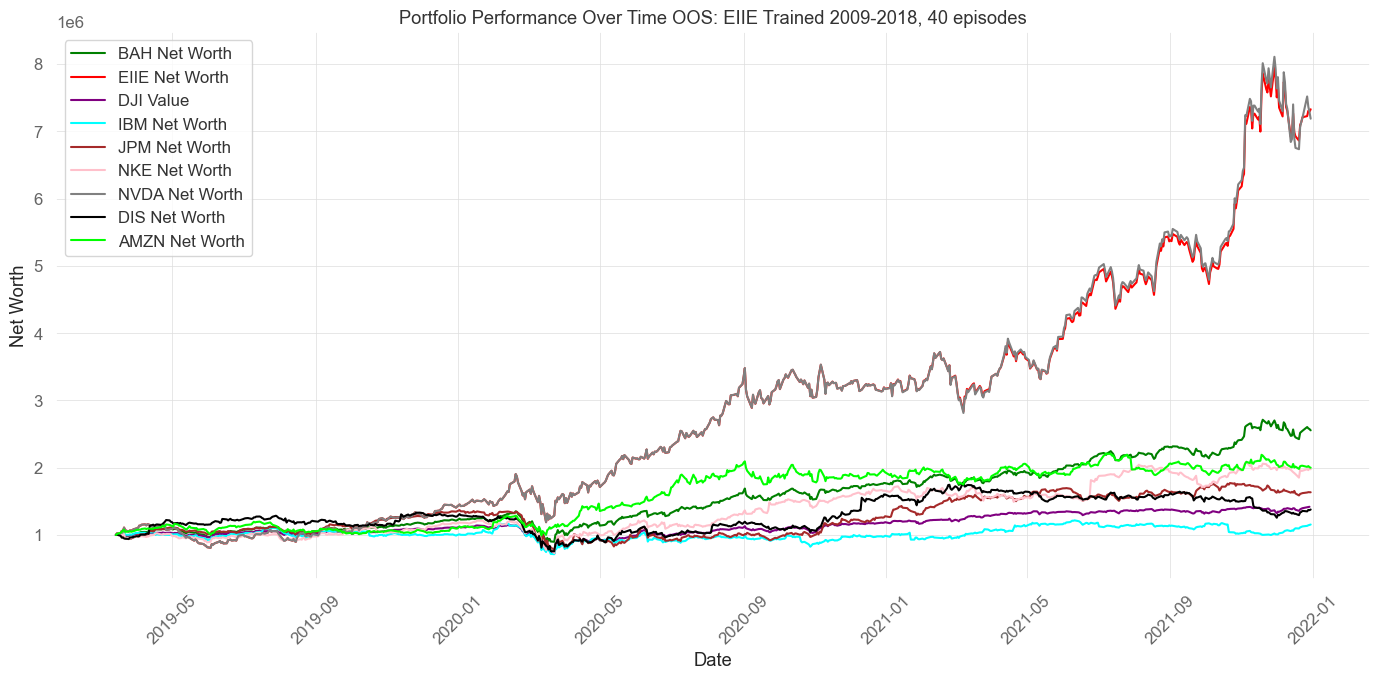

In [70]:
import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'IBM Net Worth': 'cyan',
    'JPM Net Worth': 'brown',
    'NKE Net Worth': 'pink',
    'NVDA Net Worth': 'gray',
    'DIS Net Worth': 'black',
    'AMZN Net Worth': 'lime'
}

# Plot 1: OOS Portfolio Performance
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.plot(merged_df['Date'], merged_df['IBM_net_worth'], label='IBM Net Worth', color=color_map['IBM Net Worth'])
plt.plot(merged_df['Date'], merged_df['JPM_net_worth'], label='JPM Net Worth', color=color_map['JPM Net Worth'])
plt.plot(merged_df['Date'], merged_df['NKE_net_worth'], label='NKE Net Worth', color=color_map['NKE Net Worth'])
plt.plot(merged_df['Date'], merged_df['NVDA_net_worth'], label='NVDA Net Worth', color=color_map['NVDA Net Worth'])
plt.plot(merged_df['Date'], merged_df['DIS_net_worth'], label='DIS Net Worth', color=color_map['DIS Net Worth'])
plt.plot(merged_df['Date'], merged_df['AMZN_net_worth'], label='AMZN Net Worth', color=color_map['AMZN Net Worth'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [71]:
import pprint

final_returns = {
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'NVDA': merged_df['NVDA_net_worth'].iloc[-1],
    'IBM': merged_df['IBM_net_worth'].iloc[-1],
    'JPM': merged_df['JPM_net_worth'].iloc[-1],
    'AMZN': merged_df['AMZN_net_worth'].iloc[-1],
    'NKE': merged_df['NKE_net_worth'].iloc[-1],
    'DIS': merged_df['DIS_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'AMZN': 2000266.625,
 'BAH': 2555496.5,
 'CRP': 2209474.0,
 'DIS': 1378719.875,
 'EIIE': 7326404.0,
 'IBM': 1155630.875,
 'JPM': 1634871.375,
 'NKE': 1976744.0,
 'NVDA': 7186739.0}


In [72]:
import numpy as np
import pprint


# Calculate daily returns for each specified portfolio
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['NVDA_opt_daily_return'] = merged_df['NVDA_net_worth'].pct_change()
merged_df['IBM_opt_daily_return'] = merged_df['IBM_net_worth'].pct_change()
merged_df['JPM_opt_daily_return'] = merged_df['JPM_net_worth'].pct_change()
merged_df['AMZN_opt_daily_return'] = merged_df['AMZN_net_worth'].pct_change()
merged_df['DIS_opt_daily_return'] = merged_df['DIS_net_worth'].pct_change()
merged_df['NKE_opt_daily_return'] = merged_df['NKE_net_worth'].pct_change()

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate the Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'].dropna(), risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'].dropna(), risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'].dropna(), risk_free_rate),
    'NVDA': calculate_sharpe_ratio(merged_df['NVDA_opt_daily_return'].dropna(), risk_free_rate),
    'IBM': calculate_sharpe_ratio(merged_df['IBM_opt_daily_return'].dropna(), risk_free_rate),
    'JPM': calculate_sharpe_ratio(merged_df['JPM_opt_daily_return'].dropna(), risk_free_rate),
    'AMZN': calculate_sharpe_ratio(merged_df['AMZN_opt_daily_return'].dropna(), risk_free_rate),
    'DIS': calculate_sharpe_ratio(merged_df['DIS_opt_daily_return'].dropna(), risk_free_rate),
    'NKE': calculate_sharpe_ratio(merged_df['NKE_opt_daily_return'].dropna(), risk_free_rate),

}


pprint.pprint(sharpe_ratios)

{'AMZN': 0.924545702561799,
 'BAH': 1.26253259407862,
 'CRP': 1.1422505093183508,
 'DIS': 0.44250778938789176,
 'EIIE': 1.7085541098331052,
 'IBM': 0.2565945914164192,
 'JPM': 0.6082981267870853,
 'NKE': 0.8550332692973005,
 'NVDA': 1.6697130583480158}


In [73]:
import numpy as np
import pandas as pd


# Define a function to calculate the max drawdown
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

# Calculate max drawdowns for each portfolio
max_drawdowns = {
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'NKE': max_drawdown(merged_df['NKE_net_worth']),
    'DIS': max_drawdown(merged_df['DIS_net_worth']),
    'JPM': max_drawdown(merged_df['JPM_net_worth']),
    'AMZN': max_drawdown(merged_df['AMZN_net_worth']),
    'IBM': max_drawdown(merged_df['IBM_net_worth']),
    'NVDA': max_drawdown(merged_df['NVDA_net_worth']),
}

pprint.pprint(max_drawdowns)


{'AMZN': -0.2274470227384573,
 'BAH': -0.33518049483245294,
 'CRP': -0.3388922289846029,
 'DIS': -0.43106166493456965,
 'EIIE': -0.3754533281460045,
 'IBM': -0.38980109380637773,
 'JPM': -0.43626509949455994,
 'NKE': -0.3978368056392497,
 'NVDA': -0.3755403027597063}


In [74]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'NKE': calculate_up_days_ratio(merged_df['NKE_opt_daily_return']),
    'DIS': calculate_up_days_ratio(merged_df['DIS_opt_daily_return']),
    'JPM': calculate_up_days_ratio(merged_df['JPM_opt_daily_return']),
    'IBM': calculate_up_days_ratio(merged_df['IBM_opt_daily_return']),
    'AMZN': calculate_up_days_ratio(merged_df['AMZN_opt_daily_return']),
    'NVDA': calculate_up_days_ratio(merged_df['NVDA_opt_daily_return']),
}

pprint.pprint(up_days_ratios)

{'AMZN': 0.5339943342776204,
 'BAH': 0.5679886685552408,
 'CRP': 0.5637393767705382,
 'DIS': 0.5028328611898017,
 'EIIE': 0.5552407932011332,
 'IBM': 0.5283286118980169,
 'JPM': 0.5155807365439093,
 'NKE': 0.5240793201133145,
 'NVDA': 0.5524079320113314}


In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.001111     1.0  1.871582  0.171512
Residual   0.836990  1410.0       NaN       NaN


In [76]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.010110
2      0.003273
3      0.003631
4     -0.004353
5      0.011823
         ...   
702    0.005935
703    0.021804
704   -0.007576
705   -0.004190
706   -0.007075
Name: BAH_opt_daily_return, Length: 706, dtype: float64
t-statistic: 1.368057711087528
p-value: 0.17151198441468957
